In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional

def visualize_outputs_and_targets(
    targets: pd.DataFrame,
    plots_dir: Path,
    file_name: str = "test.png",
    return_fig: bool = False,
    channel_labels: Optional[list[str]] = None,
    predictions: Optional[pd.DataFrame] = None,
    selected_channels: Optional[list[int]] = None,
) -> plt.Figure | None:

    # Determine which channels to plot
    n_channels: int = targets.shape[-1]
    if selected_channels is None:
        selected_channels = list(range(n_channels))

    if channel_labels is None:
        channel_labels = [f"Channel {i}" for i in range(n_channels)]

    # Create subplots for only the selected channels
    fig, _ = plt.subplots(
        ncols=1,
        nrows=len(selected_channels),
        figsize=(10, 2 * len(selected_channels)),
        sharex=True,
        squeeze=False,
    )

    for i, (ax, channel) in enumerate(zip(fig.axes, selected_channels)):
        # Plot target in orange
        sns.lineplot(
            data=targets.iloc[:, channel],
            ax=ax,
            linewidth=0.7,
            label="Target",
            color=(1.0, 0.498, 0.055),
            alpha=0.8 if predictions is not None else 1.0,
        )

        # Plot prediction in blue if provided
        if predictions is not None:
            sns.lineplot(
                data=predictions.iloc[:, channel],
                ax=ax,
                linewidth=0.7,
                label="Prediction",
                color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
                alpha=0.8,
            )

        # Labels and formatting
        ax.set_ylabel(channel_labels[channel], fontsize=12)
        ax.tick_params(axis='both', labelsize=10)
        ax.set_xlim(-100, len(targets) + 100)
        ax.grid(True)

        # Legend: only on first subplot if predictions are provided
        if predictions is not None and i == 0:
            ax.legend(loc="upper right", fontsize=10)
        else:
            ax.get_legend().remove()

    fig.supylabel("Firing rate [Hz]", fontsize=14)
    fig.supxlabel("Time step", fontsize=14)

    fig.tight_layout()
    fig.savefig(plots_dir / file_name, dpi=300)

    if return_fig:
        return fig
    return None


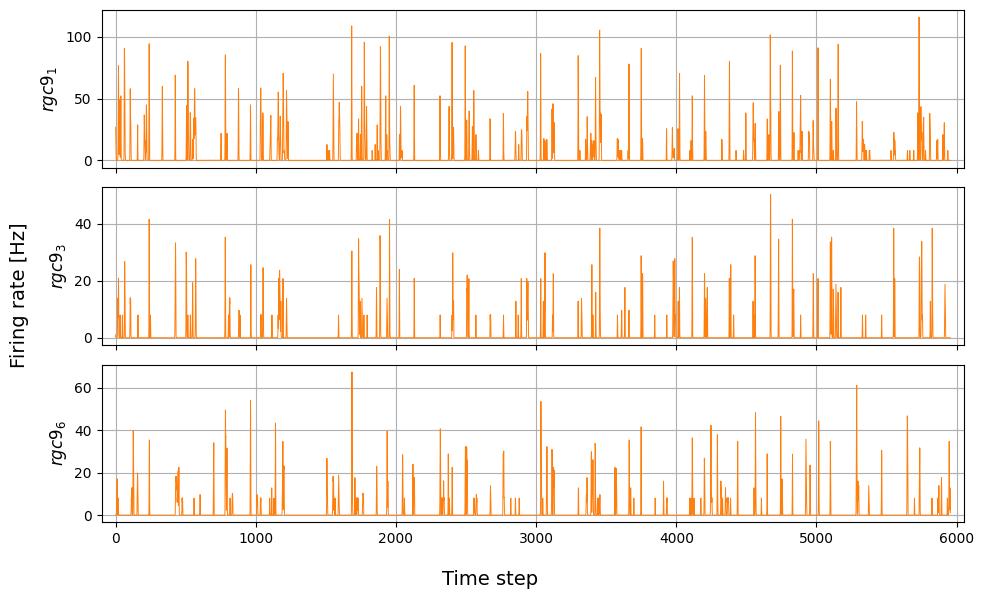

In [ ]:
targets = pd.read_csv("unscaled_targets.csv")
predictions = pd.read_csv("unscaled_outputs.csv")

num_channels = 9 # 9, 14, 27
dataset_name = "rgc"
selected_channels = [0, 2, 5]

visualize_outputs_and_targets(
    targets=targets,
    plots_dir=Path("plots"),
    file_name="test.png",
    return_fig=False,
    selected_channels=selected_channels,  # Example of selecting specific channels
    channel_labels=[f"${dataset_name}{num_channels}_{{{c+1}}}$" for c in range(num_channels)],
    # predictions=predictions
)

In [26]:
sns.color_palette("tab10")[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)